In [25]:
!pip install biopython pyBigWig

In [26]:
from Bio import SeqIO
import pandas as pd
import pyBigWig
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import torch.nn as nn
import torch
import os
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr


In [27]:
output_file = "/kaggle/working/dataset3"

In [28]:
# !pip install -U --no-cache-dir gdown

# import gdown

# file_id = '10LKzXMjZxLMGMOeyLHBGdHiZT85FoW0u'
# url = f'https://drive.google.com/uc?id={file_id}'
# output = 'dataset3'

# gdown.download(url, output, quiet=False)



Downloading...
From (original): https://drive.google.com/uc?id=10LKzXMjZxLMGMOeyLHBGdHiZT85FoW0u
From (redirected): https://drive.google.com/uc?id=10LKzXMjZxLMGMOeyLHBGdHiZT85FoW0u&confirm=t&uuid=5335d778-3470-4287-ad13-4b359939a277
To: /kaggle/working/dataset3
100%|██████████| 857M/857M [00:04<00:00, 176MB/s]  


'dataset3'

In [29]:
if not os.path.exists(output_file):
    genome_file = "GRCh38.primary_assembly.genome.fa"
    genome = SeqIO.to_dict(SeqIO.parse(genome_file, "fasta"))
    print("Chromosomes loaded:", list(genome.keys())[:5])

In [30]:
if not os.path.exists(output_file):
    gtf_file = "gencode.v49.primary_assembly.basic.annotation.gtf"
    genes = []

    with open(gtf_file) as f:
        for line in f:
            if line.startswith("#"): continue
            fields = line.strip().split("\t")
            if fields[2] != "gene": continue
            chrom = fields[0]
            start = int(fields[3])
            end = int(fields[4])
            strand = fields[6]
            # Parse gene_id from attributes
            attr = fields[8]
            gene_id = attr.split('gene_id "')[1].split('"')[0]
            genes.append([gene_id, chrom, start, end, strand])

    genes_df = pd.DataFrame(genes, columns=["gene_id","chrom","start","end","strand"])
    print("Number of genes:", len(genes_df))
    genes_df.head()

In [31]:
if not os.path.exists(output_file):
    plus_bw = pyBigWig.open("K562_plus_unique.bigWig")
    minus_bw = pyBigWig.open("K562_minus_unique.bigWig")

In [32]:
if not os.path.exists(output_file):
    print(list(genome.keys())[:5])
    print(list(plus_bw.chroms().keys())[:5])

In [34]:

window = 16384
seq_len = 2 * window
subset_size = 78899
bin_size = 256  
num_bins = seq_len // bin_size

In [35]:

if os.path.exists(output_file):
    print("dataset.npz already exists. Skipping generation.")
else:
    print("Generating gene dataset...")

    # Filter valid chromosomes
    primary_genes_df = genes_df[
        genes_df['chrom'].isin(plus_bw.chroms().keys())
    ].reset_index(drop=True)

    primary_genes_df = primary_genes_df.iloc[:subset_size]
    genes = primary_genes_df.to_dict('records')

    print(f"Using {len(genes)} genes")

    # Integer encoding (compact)
    def int_encode(seq):
        mapping = {'A':0, 'C':1, 'G':2, 'T':3}
        return np.array([mapping.get(b, 4) for b in seq.upper()], dtype=np.int16)

    X = []
    y = []


    for row in genes:
        chrom = row['chrom']
        strand = row['strand']
        tss = row['start'] if strand == '+' else row['end']

        chrom_len = plus_bw.chroms()[chrom]
        seq_start = max(0, tss - window)
        seq_end = min(chrom_len, tss + window)

        seq = genome[chrom].seq[seq_start:seq_end]
        if strand == '-':
            seq = seq.reverse_complement()

        # Encode sequence
        seq_array = int_encode(str(seq))

        if len(seq_array) < seq_len:
            seq_array = np.pad(
                seq_array,
                (0, seq_len - len(seq_array)),
                mode='constant',
                constant_values=4
            )

        X.append(seq_array)

        # CAGE signal
        plus_signal = np.nan_to_num(
            plus_bw.values(chrom, seq_start, seq_end, numpy=True)
        )
        minus_signal = np.nan_to_num(
            minus_bw.values(chrom, seq_start, seq_end, numpy=True)
        )

        total_signal = plus_signal + minus_signal

        if len(total_signal) < seq_len:
            total_signal = np.pad(
                total_signal,
                (0, seq_len - len(total_signal)),
                mode='constant'
            )

        binned_signal = []

        for i in range(num_bins):
            start = i * bin_size
            end = start + bin_size
            binned_signal.append(total_signal[start:end].sum())

        y.append(np.array(binned_signal, dtype=np.float32))
        
    # Convert once at end
    X = np.array(X, dtype=np.int16)
    y = np.array(y, dtype=np.float32)

    np.savez_compressed(output_file, X=X, y=y)

    print("Saved dataset.npz")
    print("X shape:", X.shape)
    print("y shape:", y.shape)

dataset.npz already exists. Skipping generation.


In [36]:
class GeneDataset(Dataset):
    def __init__(self, npz_path):
        data = np.load(npz_path)
        self.X = data["X"]              # (35000, 14000)
        self.y = data["y"]              # (35000, 109), already float32

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.long)
        y = torch.tensor(self.y[idx], dtype=torch.float32)  # shape (109,)
        return x, y
    
dataset = GeneDataset(output_file)
print("Total samples:", len(dataset))
print("Sample y shape:", dataset[0][1].shape)  # should be (num_bins,)

Total samples: 78691
Sample y shape: torch.Size([256])


In [37]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size]
)


In [38]:
batch_size = 32  # adjust based on GPU memory

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size)
test_loader  = DataLoader(test_dataset, batch_size=batch_size)

In [39]:


# ---------------------------
# Attention Pool
# ---------------------------
class AttentionPool(nn.Module):
    def __init__(self, pool_size, channels):
        super().__init__()
        self.pool_size = pool_size
        self.weight_proj = nn.Conv1d(channels, channels, kernel_size=1)

    def forward(self, x):
        B, C, L = x.shape
        
        # NEW: Check if L is divisible by pool_size. If not, pad the last dimension.
        remainder = L % self.pool_size
        if remainder != 0:
            pad_len = self.pool_size - remainder
            x = F.pad(x, (0, pad_len)) # Pads the sequence dimension L
            L = x.shape[-1] # Update L after padding

        weights = self.weight_proj(x)

        x = x.view(B, C, L // self.pool_size, self.pool_size)
        weights = weights.view(B, C, L // self.pool_size, self.pool_size)

        weights = torch.softmax(weights, dim=-1)
        return (x * weights).sum(dim=-1)


# ---------------------------
# Conv Blocks
# ---------------------------
class ResidualConvBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(channels),
            nn.GELU(),
            nn.Conv1d(channels, channels, kernel_size=1)
        )

    def forward(self, x):
        return x + self.block(x)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=5):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(in_channels),
            nn.GELU(),
            nn.Conv1d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                padding=kernel_size // 2
            )
        )

    def forward(self, x):
        return self.block(x)


class ConvTowerBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = ConvBlock(in_channels, out_channels)
        self.res = ResidualConvBlock(out_channels)
        self.pool = AttentionPool(pool_size=2, channels=out_channels)

    def forward(self, x):
        x = self.conv(x)
        x = self.res(x)
        x = self.pool(x)
        return x


# ---------------------------
# Relative Position Encoding
# ---------------------------
class RelativePosition(nn.Module):
    def __init__(self, num_units, max_relative_position):
        super().__init__()
        self.max_relative_position = max_relative_position
        self.embeddings = nn.Parameter(
            torch.randn(2 * max_relative_position + 1, num_units)
        )

    def forward(self, length, device):
        positions = torch.arange(length, device=device)
        distances = positions[None, :] - positions[:, None]
        distances = torch.clamp(
            distances,
            -self.max_relative_position,
            self.max_relative_position
        )
        distances += self.max_relative_position
        return self.embeddings[distances]


# ---------------------------
# Multihead Attention with Relative Bias
# ---------------------------
class MultiHeadAttentionRel(nn.Module):
    def __init__(self, d_model, num_heads=8, key_size=32):
        super().__init__()

        self.num_heads = num_heads
        self.key_size = key_size
        self.inner_dim = num_heads * key_size

        self.q_proj = nn.Linear(d_model, self.inner_dim)
        self.k_proj = nn.Linear(d_model, self.inner_dim)
        self.v_proj = nn.Linear(d_model, self.inner_dim)
        self.out_proj = nn.Linear(self.inner_dim, d_model)

        self.rel_pos = RelativePosition(key_size, max_relative_position=256)

    def forward(self, x):
        B, L, C = x.shape

        q = self.q_proj(x).view(B, L, self.num_heads, self.key_size).transpose(1, 2)
        k = self.k_proj(x).view(B, L, self.num_heads, self.key_size).transpose(1, 2)
        v = self.v_proj(x).view(B, L, self.num_heads, self.key_size).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.key_size ** 0.5)

        rel_pos = self.rel_pos(L, x.device)
        rel_scores = torch.einsum('bhld,lmd->bhlm', q, rel_pos)
        scores = scores + rel_scores / (self.key_size ** 0.5)

        attn = torch.softmax(scores, dim=-1)

        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).contiguous().view(B, L, self.inner_dim)

        return self.out_proj(out)


# ---------------------------
# Transformer Block (PreNorm)
# ---------------------------
class TransformerBlock(nn.Module):
    def __init__(self, d_model=128, num_heads=8, key_size=32, ff_hidden=256):
        super().__init__()

        self.norm1 = nn.LayerNorm(d_model)
        self.attn = MultiHeadAttentionRel(d_model, num_heads, key_size)

        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_hidden),
            nn.GELU(),
            nn.Linear(ff_hidden, d_model)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x


# ---------------------------
# Enformer Mini Scalar
# ---------------------------
class EnformerMiniScalar(nn.Module):
    def __init__(self, embed_dim=16):
        super().__init__()

        # Embedding
        self.embedding = nn.Embedding(5, embed_dim)

        # Stem
        self.stem = nn.Sequential(
            nn.Conv1d(embed_dim, 64, kernel_size=15, padding=7),
            nn.GELU(),
            ResidualConvBlock(64),
            AttentionPool(pool_size=2, channels=64)
        )

        # Conv tower
        tower_channels = [64, 64, 80, 80, 96, 96, 128]        
        self.conv_tower = nn.Sequential(*[
        ConvTowerBlock(tower_channels[i], tower_channels[i+1])
            for i in range(len(tower_channels) - 1)
        ])

        # Transformer (4 layers like mini version)
        self.transformers = nn.Sequential(*[
        TransformerBlock(d_model=128, num_heads=4, ff_hidden=256)    
            for _ in range(4)
        ])

        # Pointwise
        self.final_head = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=1),
            nn.Dropout(0.05),
            nn.GELU(),
            nn.Conv1d(256, 1, kernel_size=1),
            nn.Softplus()
        )

    def forward(self, x):
        # x: (B, seq_len)

        x = self.embedding(x)      # (B, L, embed_dim)
        x = x.transpose(1, 2)      # (B, embed_dim, L)

        x = self.stem(x)
        x = self.conv_tower(x)

        x = x.transpose(1, 2)
        x = self.transformers(x)
        x = x.transpose(1, 2)

        x = self.final_head(x)
        x = x.squeeze(1)

        target_bins = 256
        if x.shape[1] > target_bins:
            x = x[:, :target_bins]
        elif x.shape[1] < target_bins:
            # Emergency fallback: if for some reason it's too short, pad it
            x = F.pad(x, (0, target_bins - x.shape[1]))

        return x


In [40]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Device set to: Apple MPS (GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Device set to: NVIDIA CUDA (GPU)")
else:
    device = torch.device("cpu")
    print("Device set to: CPU")



Device set to: NVIDIA CUDA (GPU)


In [41]:
model = EnformerMiniScalar().to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model).to(device)
    
loss_fn = nn.PoissonNLLLoss(log_input=False, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Using 2 GPUs!


In [42]:
train = False

In [43]:
if not train:

    state_dict = torch.load('/kaggle/input/models/faraztehrani226/enformer/pytorch/default/1/best_enformer_mini_scalar.pt', map_location=torch.device('cpu'))
    
    model.load_state_dict(state_dict)
    
    model.eval()

In [44]:
if train:
    num_epochs = 20
    best_val_corr = -float('inf')
    
    train_losses = []
    val_losses = []
    train_corrs = []
    val_corrs = []
    
    patience = 5
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        # ---------------------------
        # Training
        # ---------------------------
        model.train()
        total_loss = 0
        all_preds = []
        all_trues = []
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
    
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * X_batch.size(0)
    
            # Store for correlation
            all_preds.append(y_pred.detach().cpu().numpy())
            all_trues.append(y_batch.detach().cpu().numpy())
    
        train_loss = total_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
    
        # Compute Pearson correlation on log1p counts
    
        log_preds = np.log1p(np.concatenate(all_preds, axis=0))
        log_trues = np.log1p(np.concatenate(all_trues, axis=0))
        train_corr, _ = pearsonr(log_preds.flatten(), log_trues.flatten())    
    
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Pearson R: {train_corr:.4f}")
    
        # ---------------------------
        # Validation
        # ---------------------------
        model.eval()
        val_loss = 0
        all_preds = []
        all_trues = []
    
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                y_pred = model(X_batch)
                val_loss += loss_fn(y_pred, y_batch).item() * X_batch.size(0)
    
                all_preds.append(y_pred.cpu().numpy())
                all_trues.append(y_batch.cpu().numpy())
    
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
    
        all_preds = np.concatenate(all_preds, axis=0)
        all_trues = np.concatenate(all_trues, axis=0)
        val_corr, _ = pearsonr(np.log1p(all_preds).flatten(), np.log1p(all_trues).flatten())
    
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Pearson R: {val_corr:.4f}")
    
        # ---------------------------
        # Save model checkpoint
        # ---------------------------
        if val_corr > best_val_corr:
            best_val_corr = val_corr
            torch.save(model.state_dict(), "best_enformer_mini_scalar.pt")
            print(f"Saved new best model at epoch {epoch+1} with val corr {val_corr:.4f}")
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
    
        if epochs_without_improvement > patience:
            print("Early stopping triggered")
            break


In [45]:
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_trues = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)

            all_preds.append(y_pred.cpu().numpy())
            all_trues.append(y_batch.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)  # shape (num_samples, num_bins)
    all_trues = np.concatenate(all_trues, axis=0)

    # log1p transform (like Enformer paper)
    log_preds = np.log1p(all_preds)
    log_trues = np.log1p(all_trues)

    pearson_r, _ = pearsonr(log_preds, log_trues)
    spearman_r, _ = spearmanr(log_preds, log_trues)

    return pearson_r, spearman_r, log_preds, log_trues

In [48]:

val_pearson, val_spearman, val_preds, val_trues = evaluate_model(model, val_loader)

print(f"Final Validation Pearson R: {np.mean(val_pearson):.4f}")
print(f"Final Validation Spearman R: {np.mean(val_spearman):.4f}")

Final Validation Pearson R: 0.4773
Final Validation Spearman R: 0.3582


In [49]:
test_pearson, test_spearman, test_preds, test_trues = evaluate_model(model, test_loader)

print(f"Final TEST Pearson R: {np.mean(test_pearson):.4f}")
print(f"Final TEST Spearman R: {np.mean(test_spearman):.4f}")

Final TEST Pearson R: 0.4221
Final TEST Spearman R: 0.3541


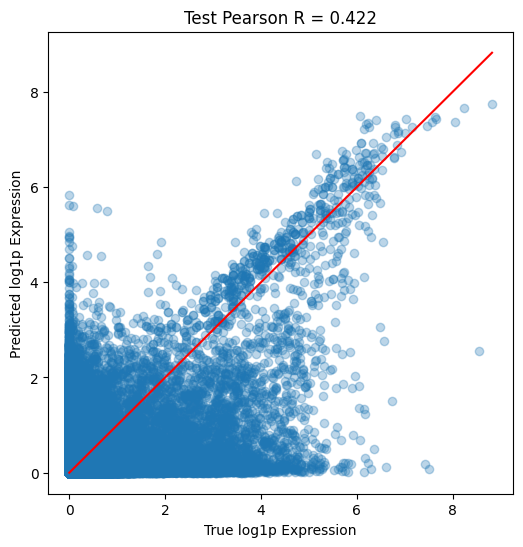

In [51]:
plt.figure(figsize=(6,6))
plt.scatter(
    test_trues.flatten(), 
    test_preds.flatten(), 
    alpha=0.3
)
plt.xlabel("True log1p Expression")
plt.ylabel("Predicted log1p Expression")
plt.title(f"Test Pearson R = {np.mean(test_pearson):.3f}")
plt.plot(
    [test_trues.min(), test_trues.max()],
    [test_trues.min(), test_trues.max()],
    color="red"
)
plt.show()

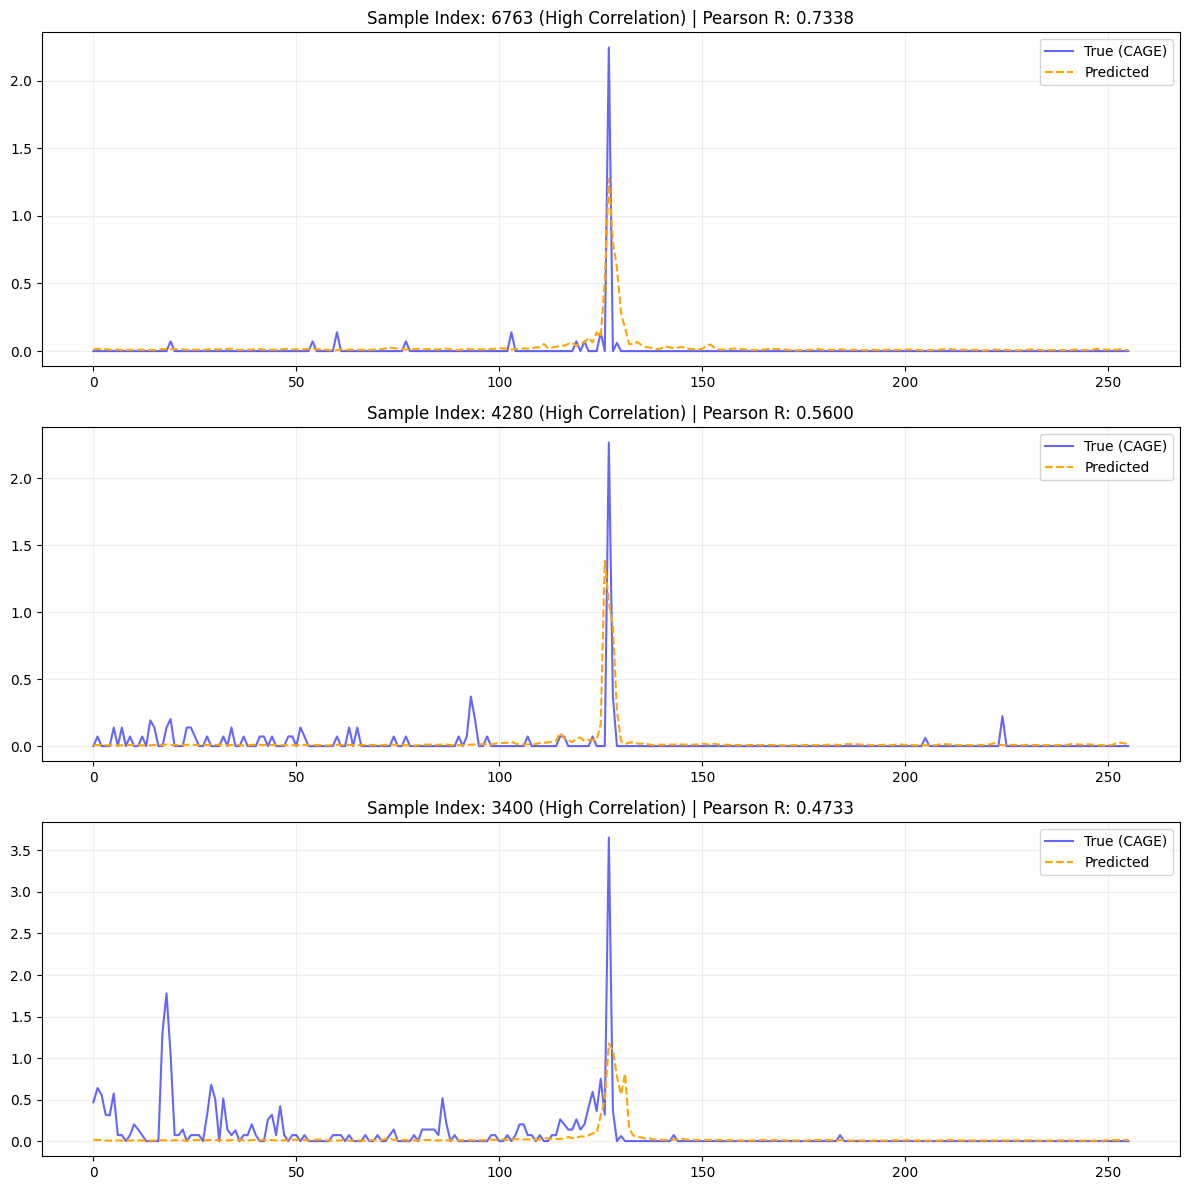

In [61]:

# 1. Calculate individual correlations
individual_corrs = []
for i in range(len(test_trues)):
    if np.std(test_trues[i]) > 1e-6 and np.std(test_preds[i]) > 1e-6:
        corr, _ = pearsonr(test_trues[i], test_preds[i])
        individual_corrs.append(corr)
    else:
        individual_corrs.append(0.0)
individual_corrs = np.array(individual_corrs)

target_indices = np.where((individual_corrs >= 0.40) & (individual_corrs <= 0.80))[0]

if len(target_indices) > 0:
    # Pick up to 3 random ones from this specific range
    num_to_plot = min(3, len(target_indices))
    selected_idxs = np.random.choice(target_indices, num_to_plot, replace=False)

    # 3. Plot them
    fig, axes = plt.subplots(num_to_plot, 1, figsize=(12, 4 * num_to_plot))
    if num_to_plot == 1: axes = [axes] # Ensure axes is iterable
    
    for i, idx in enumerate(selected_idxs):
        axes[i].plot(test_trues[idx], label="True (CAGE)", color='blue', alpha=0.6)
        axes[i].plot(test_preds[idx], label="Predicted", color='orange', linestyle='--')
        axes[i].set_title(f"Sample Index: {idx} (High Correlation) | Pearson R: {individual_corrs[idx]:.4f}")
        axes[i].legend()
        axes[i].grid(alpha=0.2)

    plt.tight_layout()
    plt.show()
